In [ ]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, Reshape
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import callbacks
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import math
import os # Импортируем библиотеку os для раоты с фаловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
from google.colab import drive
import datetime

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_zip   = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Control_points/CP3/food-23.zip' # Файл с датасетом машин
dataset = '/content/food-23'

In [ ]:
!rm -rf {dataset}

In [ ]:
!unzip -q {dataset_zip} -d {dataset}

In [ ]:
# словарь с таблицами вероятностей
labels = {}
labels['creme_brulee'] = [1,0,0,0,0]
labels['cup_cakes']    = [0,1,0,0,0]
labels['donuts']       = [0,0,1,0,0]
labels['escargots']    = [0,0,0,1,0]
labels['filet_mignon'] = [0,0,0,0,1]

# список для удобного обращения к названию по индексу
labels_list = ["creme_brulee", "cup_cakes", "donuts", "escargots", "filet_mignon"]

In [ ]:
def format_is_album(w: int, h: int):
  return True if w > h else False

# Функция умной обрезки
def smart_trimming(img):
  img_w, img_h = img.size   # Берём размер картинки
  target_size = [120, 120]  # Размер, который мы должны получить в результате

  # Проверка на формат
  if format_is_album(img_w, img_h):
    new_h = target_size[1]                # Делаем высоту основной осью
    new_w = round(new_h / img_h * img_w)  # Считаем ширину
  else:
    new_w = target_size[0]                # Делаем ширину основной осью
    new_h = round(new_w / img_w * img_h)  # Считаем высоту

  # Применяем наши измениния касательно размеров
  img = img.resize((new_w, new_h), Image.ANTIALIAS)

  # Находим центр картинки
  center = [new_w//2, new_h//2]
  # Находим левую верхнюю и правую нижнюю точки для прямоугольной обрезки
  top_left = [center[0] - target_size[0]//2, center[1] - target_size[1]//2]
  bottom_right = [center[0] + target_size[0]//2, center[1] + target_size[1]//2]

  # Обрезаем изображение
  img = img.crop((top_left[0], top_left[1], bottom_right[0], bottom_right[1]))

  return img

In [ ]:
# списки с ссылками на картинки (один список - для общей выборки, второй список - для тестовой)

image_list = []
test_image_list = []

# проходимся по папкам
for label in labels.keys():
  dir = dataset +"/" + label
  flist = os.listdir(dataset + "/" + label)
  test_count = 0
  for f in flist:
    # первые две картинки добавляем в список тестовой выборки
    if test_count < 2:
      fpath = dataset+ "/" + label + "/" + f
      test_image_list.append(fpath)
      
      test_count += 1
      continue

    # этот код выполняется с остальными картинками
    fpath = dataset+ "/" + label + "/" + f
    image_list.append(fpath)

# перемешиваем оба списка
random.shuffle(image_list)
random.shuffle(test_image_list)

# создаём пустые списки для выборок
x_train = []
y_train = []

x_test = []
y_test = []

# добавляем картинки в x_test, соответствующие названия в y_test
for fpath in test_image_list:
  img = Image.open(fpath)
  img = smart_trimming(img)

  img = np.array(img)

  # Фильтрация изображений от других цветовых форматов.
  # Без неё получится преобразовать массивы выборок в np массивы.
  # print(img.shape)

  x_test.append(img)

  label = fpath.split('/')[3]
  y_test.append(labels[label])

# аналогично заполняем общие выборки
for fpath in image_list:
  img = Image.open(fpath)
  img = smart_trimming(img)

  img = np.array(img)

  # Фильтрация изображений от других цветовых форматов.
  # Без неё получится преобразовать массивы выборок в np массивы.
  # print(img.shape)

  x_train.append(img)

  label = fpath.split('/')[3]
  y_train.append(labels[label])

In [ ]:
# проверка размеров списков
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4990 4990
10 10


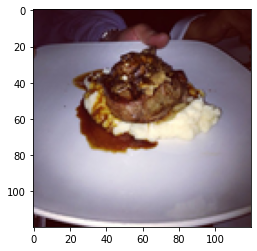

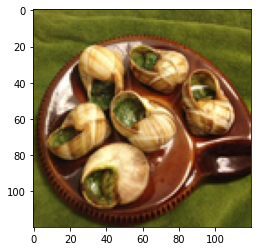

In [ ]:
# проверка картинок в списках
plt.imshow(x_train[67])
plt.show()

plt.imshow(x_test[0])
plt.show()

In [ ]:
# "превращаем" списки в np.array + создаём валидационную выборку

x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = x_train[4000:]
y_val = y_train[4000:]

x_train = x_train[:4000]
y_train = y_train[:4000]

x_test = np.array(x_test)
y_test = np.array(y_test)

# проверяем размер x_val
print(x_val.shape)

(990, 120, 120, 3)


In [ ]:
# модель функциональной нейронной сети

batch_size = 16

img_input = Input((120, 120, 3))

# первая ветка

x = BatchNormalization()(img_input)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

# вторая ветка

y = BatchNormalization()(img_input)
y = Conv2D(32, (2, 2), padding='same', activation='relu')(y)
y = MaxPooling2D()(y)
y = Dropout(0.3)(y)

y = BatchNormalization()(y)
y = Conv2D(64, (2, 2), padding='same', activation='relu')(y)
y = MaxPooling2D()(y)
y = Dropout(0.3)(y)

# соединяем ветки
a = concatenate([x,y])

a = BatchNormalization()(a)
a = Conv2D(128, (3, 3), padding='same', activation='relu')(a)
a = MaxPooling2D()(a)
a = Dropout(0.3)(a)

a = BatchNormalization()(a)
a = Flatten()(a)
a = Dense(5, activation='softmax')(a)

model_func = Model(img_input, a)

In [ ]:
# описание модели
model_func.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 120, 120, 3)  12         ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 120, 120, 3)  12         ['input_2[0][0]']                
 rmalization)                                                                               

Epoch 1/10
250/250 [==============================] - 5s 15ms/step - loss: 11.0894 - accuracy: 0.3577 - val_loss: 1.4459 - val_accuracy: 0.4030
Epoch 2/10
250/250 [==============================] - 4s 14ms/step - loss: 1.2858 - accuracy: 0.4870 - val_loss: 1.3265 - val_accuracy: 0.4798
Epoch 3/10
250/250 [==============================] - 4s 14ms/step - loss: 1.2193 - accuracy: 0.5268 - val_loss: 1.3536 - val_accuracy: 0.4677
Epoch 4/10
250/250 [==============================] - 4s 14ms/step - loss: 1.1743 - accuracy: 0.5477 - val_loss: 1.2381 - val_accuracy: 0.5091
Epoch 5/10
250/250 [==============================] - 4s 14ms/step - loss: 1.1353 - accuracy: 0.5590 - val_loss: 1.5614 - val_accuracy: 0.4273
Epoch 6/10
250/250 [==============================] - 4s 14ms/step - loss: 1.0924 - accuracy: 0.5828 - val_loss: 1.3890 - val_accuracy: 0.4990
Epoch 7/10
250/250 [==============================] - 4s 14ms/step - loss: 1.0901 - accuracy: 0.5907 - val_loss: 1.4760 - val_accuracy: 0.428

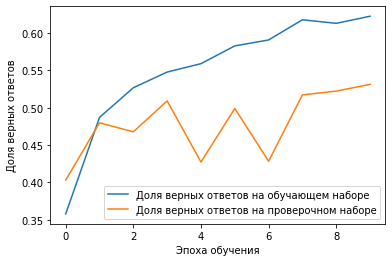

In [ ]:
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/10
250/250 [==============================] - 5s 15ms/step - loss: 0.7092 - accuracy: 0.7430 - val_loss: 1.2472 - val_accuracy: 0.5828
Epoch 2/10
250/250 [==============================] - 4s 14ms/step - loss: 0.5649 - accuracy: 0.7920 - val_loss: 1.1848 - val_accuracy: 0.5758
Epoch 3/10
250/250 [==============================] - 4s 14ms/step - loss: 0.5239 - accuracy: 0.8077 - val_loss: 1.1800 - val_accuracy: 0.5808
Epoch 4/10
250/250 [==============================] - 4s 14ms/step - loss: 0.4660 - accuracy: 0.8305 - val_loss: 1.2761 - val_accuracy: 0.5727
Epoch 5/10
250/250 [==============================] - 3s 14ms/step - loss: 0.4527 - accuracy: 0.8345 - val_loss: 1.2924 - val_accuracy: 0.5727
Epoch 6/10
250/250 [==============================] - 4s 14ms/step - loss: 0.3962 - accuracy: 0.8553 - val_loss: 1.3597 - val_accuracy: 0.5788
Epoch 7/10
250/250 [==============================] - 4s 14ms/step - loss: 0.3646 - accuracy: 0.8662 - val_loss: 1.2934 - val_accuracy: 0.5747

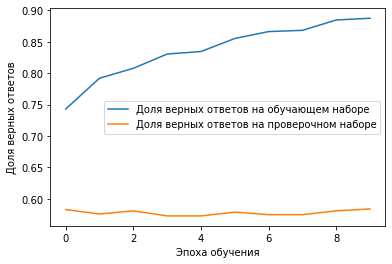

In [ ]:
model_func.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

# Обучаем сеть на наших данных
history = model_func.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=10,
                    validation_data=(x_val, y_val),
                    verbose=1)

# Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

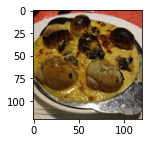

Выход сети:
[4.6432226e-05 7.7727499e-08 1.4716099e-05 9.9992120e-01 1.7594903e-05]

0 -> 0.0000464322256448213011026382446289062500
1 -> 0.0000000777274991037302243057638406753540
2 -> 0.0000147160990309203043580055236816406250
3 -> 0.9999212026596069335937500000000000000000
4 -> 0.0000175949026015587151050567626953125000

Распознан объект:  3 - escargots
Верный ответ:  3 - escargots


In [ ]:
prediction = model_func.predict(x_test)

n = 2

img = x_test[n]
img = img.reshape(120, 120, 3)
img = img.astype('uint8')
plt.figure(figsize=(2, 2))
plt.imshow(Image.fromarray(img)) #Отображаем изображение i-ым графиков
plt.show()

print("Выход сети:")
print(prediction[n])
print()
for i in range(5):
  print(i,"->","{:.40f}".format(prediction[n][i]))
print()
# print(labels[np.argmax(prediction[n])])
print("Распознан объект: ", np.argmax(prediction[n]), "-", labels_list[np.argmax(prediction[n])])
print("Верный ответ: ", np.argmax(y_test[n]), "-", labels_list[np.argmax(y_test[n])])